In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import DataLoader
from torchvision import datasets as dsets, transforms as tf
from torchvision.utils import make_grid
from collections import OrderedDict

In [22]:
data_root = '/Datasets/MNIST/.'
workers = 2
batch_size = 60
lr = 1e-3
nc=1
nz=1
nf = 64

In [23]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda else 'cpu')
device

device(type='cuda', index=0)

In [24]:
transforms = {
    'mnist': tf.Compose([
        tf.ToTensor()
    ])
}

In [25]:
train_dataset = dsets.FashionMNIST(root=data_root, train=True, download=True, transform=transforms['mnist'])
test_dataset = dsets.FashionMNIST(root=data_root, train=False, download=True, transform=transforms['mnist'])

print(train_dataset, test_dataset, sep='\n\n')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Datasets/MNIST/.
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /Datasets/MNIST/.
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda)

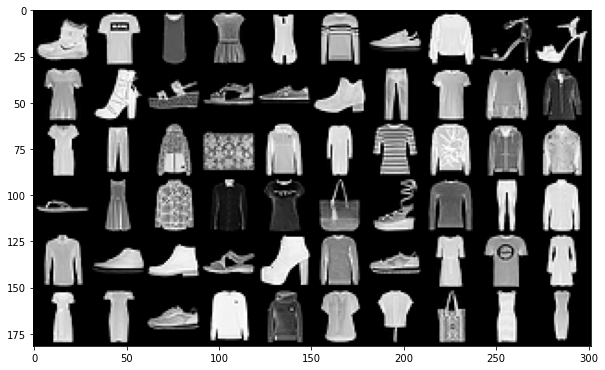

In [29]:
im = next(iter(train_loader))

grid = make_grid(im[0], nrow=10, normalize=True)

plt.figure(figsize=(10 ,9))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

In [78]:
class AutoEncoder(nn.Module):

    def __init__(self, in_channels=nc, out_channels=nz):
        super(AutoEncoder, self).__init__()
        pad = (0, 1, 0, 1)

        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=(1, 1, 1, 1)),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 4, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf * 2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=2),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            ))
        ]))

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


acNet = AutoEncoder().to(device)
acNet

AutoEncoder(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((1, 1, 1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decode): Sequential(
    (conv1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=

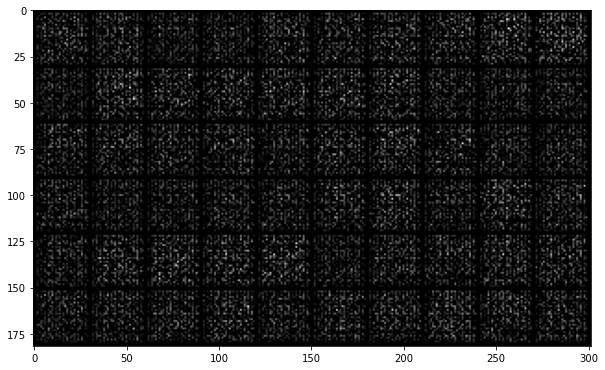

In [82]:
with torch.no_grad():
    x = acNet(im[0].to(device)).cpu()

    grid = make_grid(x, nrow=10, normalize=True)


plt.figure(figsize=(10, 9))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))